# Example 1 - ROI detection

In this notebook, we'll perform ROI detection on echograms, and evaluate its performance using annotations. 

In [13]:
import os
import numpy as np
import pandas as pd
import glob
import pickle

from src.read_echogram import EchogramReader
from src.detect_ROI import ROIDetector
from src.ROI_features import FeatureExtractor
from src.transform_annotations import AnnotationTransformer
from src.match_annotations import OverlapAnnotation
from src.crop_ROI import ROICropper

%matplotlib inline

## Step 1. Load annotations

In this step, we'll load original and transformed annotations, i.e., filename: [annotations, labels], saved as pkl file. 

In [14]:
# load original annotations (mask)
annotations_dir = "../csv/"
annotations = pd.read_csv(annotations_dir + "annotation_df_masks.csv")
# drop nan
annotations = annotations.dropna(how='any')
# add label map
label_map = {'Unclassified regions': 1, 'krill_schools': 2, 'fish_school': 3, 'AH_School': 4}

In [15]:
# select echograms with AH schools
annotations_sel = annotations[annotations['label'] == 'AH_School']
filename_li = annotations_sel['file_dir'].unique()
filename_li.sort()

In [16]:
len(filename_li)

254

In [17]:
# load transformed annotations (query)
pkl_dir = "pkl/"
with open(pkl_dir + 'annotations_dict_new.pickle', 'rb') as handle:
    annotations_dict = pickle.load(handle)

## Step 3. Parameter study (Sv threshold)

Next, let's test out threshold & recall/precion/F1. We use overlap ratio at 0.4 or 0.6?

In [18]:
# add raw and bottom file dir
raw_dir = "../data/HB1906_EK60/rawfiles/"
bot_dir = "../data/HB1906_EK60/botfiles/"
freq_li = [18, 38, 120, 200]

In [19]:
raw_paths = sorted(glob.glob(raw_dir + '*.raw'))
bot_paths = sorted(glob.glob(bot_dir + '*.bot'))

In [20]:
fig_dir = "figures/"

In [21]:
threshold_li = [-54, -56, -58, -60, -62, -64, -66, -68, -70, -72, -74, -76, -78, -80]
kernel_size = 3
overlap_ratio = 0.4

This process takes too long, try multiprocessing. Est. 15 hours. 

In [22]:
def test_threshold(a):
    i, j = a
    if i not in filename_li:
        return
    test_res = []
    echogram = EchogramReader(i, j, freq_li)
    filename, Sv_npy, surface_idx, bottom_idx, time, depth, positions = echogram()   
    annotations_idx, labels = annotations_dict[filename] # get annotation xy indices directly
    # different threshold
    for threshold in threshold_li:
        try:
            roi = ROIDetector(filename, Sv_npy, surface_idx, bottom_idx, fig_dir, threshold, kernel_size)
            img_shape, contours = roi()
            features = FeatureExtractor(filename, contours, Sv_npy, bottom_idx, time, depth, positions)                    
            contours_sel, contours_features = features() 
            overlap = OverlapAnnotation(filename, img_shape, annotations_idx, labels, contours_sel, fig_dir) 
            # object-level metrics
            counts = overlap.object_overlap_count(overlap_ratio) # set threshold   
            res_dict = {'filename': filename, 'threshold': threshold, 'kernel_size': kernel_size, 'overlap_ratio': overlap_ratio, 'annotations_valid': counts[0], 'annotations_all': counts[1], 'roi_valid': counts[2], 'roi_all': counts[3]}
            test_res.append(res_dict)
        except:
            continue
    return test_res

In [23]:
from multiprocessing import Pool
# res = []
pool = Pool(os.cpu_count())
res_li = pool.map(test_threshold, zip(raw_paths, bot_paths)) # a list of results

D20191031-T082513D20191016-T172436D20191022-T132948D20191024-T095448D20191018-T094014D20191013-T235243D20191101-T050239
D20191019-T180235






D20191101-T070625
D20191102-T181031
D20191031-T090628
D20191016-T180614
D20191104-T075532
D20191024-T103607
D20191101-T082855
D20191031-T135513
D20191024-T111726
D20191023-T011904
D20191101-T091010
D20191018-T102152
D20191031-T143628
D20191016-T184753
D20191031-T164013
D20191102-T185145
D20191024-T124006
D20191101-T095125
D20191031-T172127
D20191101-T103240
D20191024-T132127
D20191031-T180242
D20191016-T192932
D20191023-T040559
D20191101-T111355
D20191031-T192512
D20191024-T140246
D20191104-T083636
D20191101-T115511
D20191031-T204742
D20191102-T193300
D20191101-T005509
D20191018-T110329
D20191024-T152526
D20191101-T192858
D20191101-T013623
D20191024-T160645
D20191101-T201013
D20191016-T201110
D20191101-T021737
D20191101-T205128
D20191024-T164804
D20191023-T081620
D20191102-T201415
D20191101-T225534
D20191105-T213450
D20191024-T172924
D20191104-

Get recall/precision/F1 at different Sv threshold. 

In [24]:
# flat res [[], [], []]
res = []
for sublist in res_li:
    if sublist == None:
        continue
    for item in sublist:
        res.append(item)
df_threshold = pd.DataFrame(res)

In [25]:
pkl_dir = "pkl/"
df_threshold.to_pickle(pkl_dir + 'df_threshold.pkl')

In [26]:
pool.close()
pool.join()

In [33]:
# check performance
res_plot = []
for threshold in threshold_li:
    df = df_threshold[df_threshold['threshold']==threshold]
    recall = df['annotations_valid'].sum() / df['annotations_all'].sum()
    precision = df['roi_valid'].sum() / df['roi_all'].sum()
    F1 = 1.0/(1.0/recall + 1.0/precision)
    res_plot.append({'threshold': threshold, 'recall': recall, 'precision': precision, 'F1': F1})
    print(f'threshold: {threshold}, recall: {recall}, precision: {precision}, F1: {F1}')

threshold: -54, recall: 0.05463182897862233, precision: 0.440337909186906, F1: 0.048601891171492564
threshold: -56, recall: 0.08123515439429929, precision: 0.46337579617834396, F1: 0.0691179718394373
threshold: -58, recall: 0.11401425178147269, precision: 0.473967684021544, F1: 0.09190600522193212
threshold: -60, recall: 0.1667458432304038, precision: 0.49513776337115073, F1: 0.12473819119415061
threshold: -62, recall: 0.28741092636579574, precision: 0.509112426035503, F1: 0.1837039347937177
threshold: -64, recall: 0.643230403800475, precision: 0.41631186801490155, F1: 0.252735976745264
threshold: -66, recall: 0.9135391923990499, precision: 0.17770936822220668, F1: 0.14876947249766456
threshold: -68, recall: 0.9434679334916865, precision: 0.05685845712992987, F1: 0.05362662782151073
threshold: -70, recall: 0.8679334916864608, precision: 0.02342840831741431, F1: 0.022812619919587232
threshold: -72, recall: 0.8038004750593825, precision: 0.01125058520599251, F1: 0.011095287368043456
thre

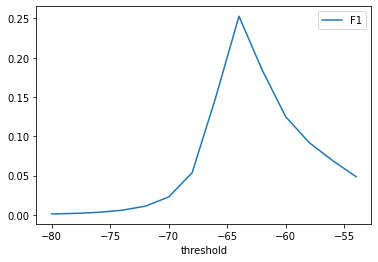

In [35]:
df_group = pd.DataFrame(res_plot)
lines = df_group.plot.line(x='threshold', y='F1')

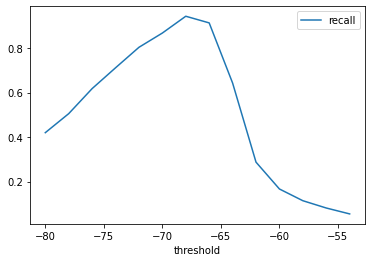

In [36]:
lines = df_group.plot.line(x='threshold', y='recall')

## Step 4. Check depth issue

The original echogram's depth starts at 7.5m, while annotations start at 6m, add 1.5m as offset. 

In [ ]:
print(depth) # depth varies, 6m or 7.5m, annotations, buffer 6m, add offset